In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

Read in data to generate Pandas dataframe. If generating for the first time, will take about five minutes. Otherwise, it should take about 10 seconds.

In [2]:
datapath = '../data/Pose_Dataset/'
nFrames = 300 # number of frames per squat
df_filename = '../data/all-data.pkl' # where to save concatenated data
np_filename = '../data/np-data.npy'
name_to_label = {
    'bad_inner_thigh': 0,
    'bad_back_round': 1,
    'bad_back_warp': 2,
    'bad_head': 3,
    'bad_shallow': 4,
    'bad_toe': 5,
    'good': 6
}

if os.path.exists(df_filename) and os.path.exists(np_filename):
    # read in pkl file
    df = pd.read_pickle(df_filename)
    with open(np_filename, 'rb') as f:
        X_train = np.load(f)
        y_train = np.load(f)
        X_val = np.load(f)
        y_val = np.load(f)
        X_test = np.load(f)
        y_test = np.load(f)
else:
    # generate pkl file and npy file

    # initialize arrays to fill in each loop iteration
    filenames = []
    datas = []
    np_datas = []
    labels = []

    # read in each squat file
    for cur_dir, _, files in os.walk(datapath):
        for file in files:
            if not file.endswith('.json'):
                continue
            filename = os.path.join(cur_dir, file)
            filenames.append(filename)

            data = pd.read_json(filename).to_numpy()
            data = data[1,0:nFrames] # get data for frames. Note some files have 301 frames, truncate all to first 300
            datas.append(data)
            np_data = np.array([np.array(d) for d in data])
            if np_data.shape == (300, 171):
                np_datas.append(np_data)
            labels.append(name_to_label[cur_dir.split('/')[-2]])
        print(f"Done processing {cur_dir}")

    # move arrays into dataframe
    datas = np.array(datas) # convert to array so we can loop through
    d = {'filename': filenames}
    for i in range(nFrames):
        d[str(i)] = datas[:,i]
    df = pd.DataFrame(data=d)

    # save to pkl
    df.to_pickle(df_filename)

    # write data into numpy arrays and save
    np_datas = np.stack(np_datas)
    labels = np.array(labels)

    n = np_datas.shape[0]
    split_indices = [int(n * 0.8), int(n * 0.9)]
    train_indices, val_indices, test_indices = np.split(np.random.choice(n, n, replace=False), split_indices)

    X_train = np_datas[train_indices]
    y_train = labels[train_indices]

    X_val = np_datas[val_indices]
    y_val = labels[val_indices]

    X_test = np_datas[test_indices]
    y_test = labels[test_indices]
    
    with open(np_filename, 'wb') as f:
        np.save(f, X_train)
        np.save(f, y_train)
        np.save(f, X_val)
        np.save(f, y_val)
        np.save(f, X_test)
        np.save(f, y_test)

Add label column based on filename

In [3]:
df['label'] = [df['filename'][i].split('/')[3] for i in range(len(df))]

Print out the first five rows of the dataframe. The 'filename' column contains full filepath + name of each squat, and the remaining columns contain pose data for each of 300 frames.

In [4]:
df.head(5)

,filename,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,label
0,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.43120177353718403, 0.797377414334803, 0.844...","[0.430941564889928, 0.79869170732256, 0.847091...","[0.431044555308539, 0.799997781067416, 0.84760...","[0.431592316178638, 0.7988144430510611, 0.8469...","[0.4311132590348, 0.7942079960716251, 0.840107...","[0.43193753462167306, 0.7949407220012981, 0.84...","[0.432750845147567, 0.7839057041264701, 0.8325...","[0.432541413484046, 0.787418809894588, 0.83614...","[0.431894497467298, 0.786059366307652, 0.83555...",...,"[0.43357581090852304, 0.7943466004531391, 0.84...","[0.433069769111656, 0.7938311318961081, 0.8431...","[0.431030331629899, 0.786474443905499, 0.83585...","[0.43115121328079503, 0.7842615868752231, 0.83...","[0.43390441871996305, 0.7924671389584511, 0.84...","[0.43198091643781905, 0.7867065528136351, 0.83...","[0.43174849778878904, 0.783046079262931, 0.836...","[0.43123957336803503, 0.787923224200576, 0.840...","[0.428997741451614, 0.780915252148985, 0.83353...",good
1,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.47551463277682005, 0.9215836428119221, 0.93...","[0.47563254721491705, 0.9217684412264681, 0.93...","[0.47606479372639904, 0.921504059759201, 0.932...","[0.476369782218, 0.920659233360356, 0.93398515...","[0.474865629960791, 0.9185499246891451, 0.9351...","[0.47621913132710003, 0.9194576930028691, 0.93...","[0.47541189727106403, 0.916291807802979, 0.935...","[0.473958178841594, 0.9117857030781501, 0.9319...","[0.47338005686455703, 0.907825476525932, 0.933...",...,"[0.43516232461652304, 0.7482315863841671, 0.81...","[0.440398428175206, 0.771004741367683, 0.83682...","[0.45157124879577604, 0.815575642811675, 0.875...","[0.456352779376737, 0.843149297107819, 0.90124...","[0.464314572629178, 0.8598558365912851, 0.9082...","[0.46697763869442105, 0.8769539497506571, 0.92...","[0.46801772225950805, 0.8857252811475381, 0.92...","[0.468906910070493, 0.89422190287234, 0.928794...","[0.47246470516002803, 0.9024032699077711, 0.93...",good
2,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.487507568770135, 0.945001119666321, 0.95042...","[0.48724964719018404, 0.9447277868278361, 0.94...","[0.48733040533680005, 0.9444814068387251, 0.95...","[0.487969080175346, 0.946172353218329, 0.95415...","[0.48801193176894003, 0.946446475083851, 0.954...","[0.48742002510173404, 0.9443007012276421, 0.95...","[0.48699883703371705, 0.944366404361722, 0.957...","[0.48672516046768005, 0.9434340433389351, 0.95...","[0.48594678261619706, 0.9419660089707981, 0.95...",...,"[0.48502701306215, 0.9386721636737401, 0.95784...","[0.48510789168053, 0.9385537482653441, 0.95760...","[0.48517004926523405, 0.9378531640723361, 0.95...","[0.485991932994121, 0.9392084318376931, 0.9576...","[0.48617870299984006, 0.9400844966051861, 0.95...","[0.48613420586339506, 0.939901991724413, 0.950...","[0.48738268976887006, 0.9421225640340241, 0.95...","[0.487048790933767, 0.941068299266387, 0.94779...","[0.48686638446639, 0.9400423518104981, 0.94476...",good
3,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.47153572199932403, 0.857707360049973, 0.912...","[0.47160060745792703, 0.8573000747132821, 0.91...","[0.47036495298267605, 0.8531030652053331, 0.90...","[0.47240727772132, 0.860811007425445, 0.915781...","[0.46991840338782903, 0.8573401020290371, 0.91...","[0.47183890308743204, 0.8578533481614711, 0.91...","[0.469546441113654, 0.85047357179348, 0.904737...","[0.472174902614971, 0.854945950506319, 0.91187...","[0.46757983379684404, 0.8449749239116151, 0.90...",...,"[0.39646774404282203, 0.6211367265235841, 0.68...","[0.401195957721987, 0.6348000804749631, 0.7068...","[0.40244821179802404, 0.6407111917934291, 0.71...","[0.40574182411201004, 0.6531848616857611, 0.72...","[0.40859117574242604, 0.6741368173148691, 0.74...","[0.409277574312078, 0.6778921720769541, 0.7455...","[0.409182634792002, 0.682084981652292, 0.75031...","[0.412567976505038, 0.69516563040747, 0.759781

In [5]:
labels = df.label.unique()
for label in labels:
    print('%s: %i' %(label,sum(df['label']==label)))

nClasses = 7

print('\n Train')
labels = df.label.unique()
for i in range(nClasses):
    print('%s: %i' %(i,sum(y_train==i)))

print('\n Val')
labels = df.label.unique()
for i in range(nClasses):
    print('%s: %i' %(i,sum(y_val==i)))

print('\n Test')
labels = df.label.unique()
for i in range(nClasses):
    print('%s: %i' %(i,sum(y_test==i)))

good: 293
bad_toe: 295
bad_shallow: 319
bad_innner_thigh: 230
bad_back_round: 280
bad_back_warp: 312
bad_head: 272

 Train
0: 177
1: 227
2: 252
3: 221
4: 249
5: 242
6: 232

 Val
0: 34
1: 28
2: 30
3: 23
4: 28
5: 25
6: 32

 Test
0: 19
1: 25
2: 30
3: 27
4: 42
5: 28
6: 29


In [6]:
# one-hot y values # REMEMBER TO ONLY RUN THIS ONCE
y_train_onehot = tf.keras.utils.to_categorical(y_train,num_classes=nClasses)
y_val_onehot = tf.keras.utils.to_categorical(y_val,num_classes=nClasses)
y_test_onehot = tf.keras.utils.to_categorical(y_test,num_classes=nClasses)

In [52]:
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)

num_hidden_units = 128
num_outputs = 7

sequential_model = tf.keras.Sequential()
sequential_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units,return_sequences=True)))
sequential_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units)))
sequential_model.add(tf.keras.layers.Dense(num_outputs,activation='softmax'))

input_layer = tf.keras.Input(shape=(nFrames, 171)) 
model = tf.keras.Model(inputs=input_layer, outputs=sequential_model(input_layer))

opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 300, 171)]        0         
_________________________________________________________________
sequential_16 (Sequential)   (None, 7)                 703239    
Total params: 703,239
Trainable params: 703,239
Non-trainable params: 0
_________________________________________________________________


In [53]:
BATCH_SIZE = 16
train_dset = tf.data.Dataset.from_tensor_slices((X_train,y_train_onehot)).batch(BATCH_SIZE)
val_dset = tf.data.Dataset.from_tensor_slices((X_val,y_val_onehot)).batch(BATCH_SIZE)
test_dset = tf.data.Dataset.from_tensor_slices((X_test,y_test_onehot)).batch(BATCH_SIZE)

In [54]:
EPOCHS=100
history = model.fit(train_dset, epochs=100, validation_data=val_dset)

Epoch 1/100
100/100 [==============================] - 6s 58ms/step - loss: 1.9760 - accuracy: 0.1650 - val_loss: 1.9688 - val_accuracy: 0.1400
Epoch 2/100
100/100 [==============================] - 5s 47ms/step - loss: 1.9462 - accuracy: 0.1569 - val_loss: 1.9609 - val_accuracy: 0.1400
Epoch 3/100
100/100 [==============================] - 5s 47ms/step - loss: 1.9360 - accuracy: 0.1575 - val_loss: 1.9384 - val_accuracy: 0.1450
Epoch 4/100
100/100 [==============================] - 5s 46ms/step - loss: 1.9275 - accuracy: 0.1663 - val_loss: 1.9446 - val_accuracy: 0.1650
Epoch 5/100
100/100 [==============================] - 5s 46ms/step - loss: 1.9183 - accuracy: 0.1688 - val_loss: 1.9467 - val_accuracy: 0.1400
Epoch 6/100
100/100 [==============================] - 5s 47ms/step - loss: 1.9269 - accuracy: 0.1688 - val_loss: 1.9425 - val_accuracy: 0.1450
Epoch 7/100
100/100 [==============================] - 5s 47ms/step - loss: 1.9080 - accuracy: 0.1912 - val_loss: 1.9181 - val_accuracy:

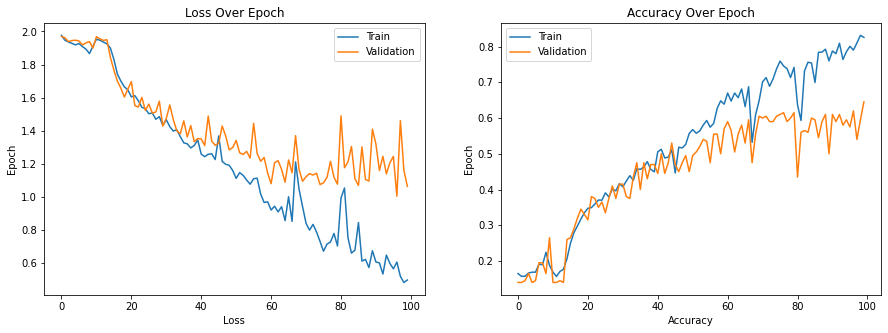

In [55]:
x = np.arange(len(history.history['accuracy']))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Loss Over Epoch")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Accuracy Over Epoch")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend()
plt.show()

plt.close()

In [56]:
# test set
(loss,accuracy) = model.evaluate(test_dset)
print('Test accuracy: %.3f' %accuracy)

13/13 [==============================] - 0s 28ms/step - loss: 1.0456 - accuracy: 0.6600
Test accuracy: 0.660


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
#Note: good source on the methods below: 
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#prelim results

#find model predictions
predictions = model.predict(test_dset)
y_pred = np.argmax(predictions, axis=1) #convert those predictions to labels

#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred, normalize = 'true') #true,pred
display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good']
df_cm = pd.DataFrame(cm, index = display_labels, columns = display_labels)
plt.figure(figsize=(10,7),dpi=300)
#sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size #,annot_kws={"size": 16}
plt.ylabel('True label', fontweight = 'bold')
plt.xlabel('Predicted label', fontweight = 'bold')
plt.title('Normalized Confusion Matrix', fontweight = 'bold')
plt.show()

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


print('\nClassification Report\n')
classification_rep = classification_report(y_test, y_pred, target_names=['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good'])
print(classification_rep)


#Cohen Kappa Statistic
print('Cohen Kappa Statistic\n')
cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)